# Train a fully connected (dense) neural network for EMNIST Digits

In [1]:
using Flux
using Statistics
using MLDatasets
using DataFrames
using OneHotArrays
using CairoMakie
using ProgressBars

## MNIST dataset

In [2]:
data = MNIST(split = :train)

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :train
  features  =>    28×28×60000 Array{Float32, 3}
  targets   =>    60000-element Vector{Int64}

### Data Exploration and Visualisation

In [3]:
data.features[:, :, 1]

28×28 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0       …  0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.215686  0.533333  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0       …  0.67451   0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.886275  0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.992157  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.831373  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0          0.992157  0.529412  0.0  0.0  0.0
 ⋮                        ⋮         ⋱                      ⋮         
 0.0  0.0  0.0  0.0  0.0  0.101961     0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.65098   …  0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  

In [4]:
data.targets[1]

5

In [5]:
"""
    pos(v, cols)

Map an integer value to a [row, col] position in a grid of `cols` columns.
"""
function pos(v, cols)
    return mod1(v, cols), div(v - 1, cols) + 1
end;

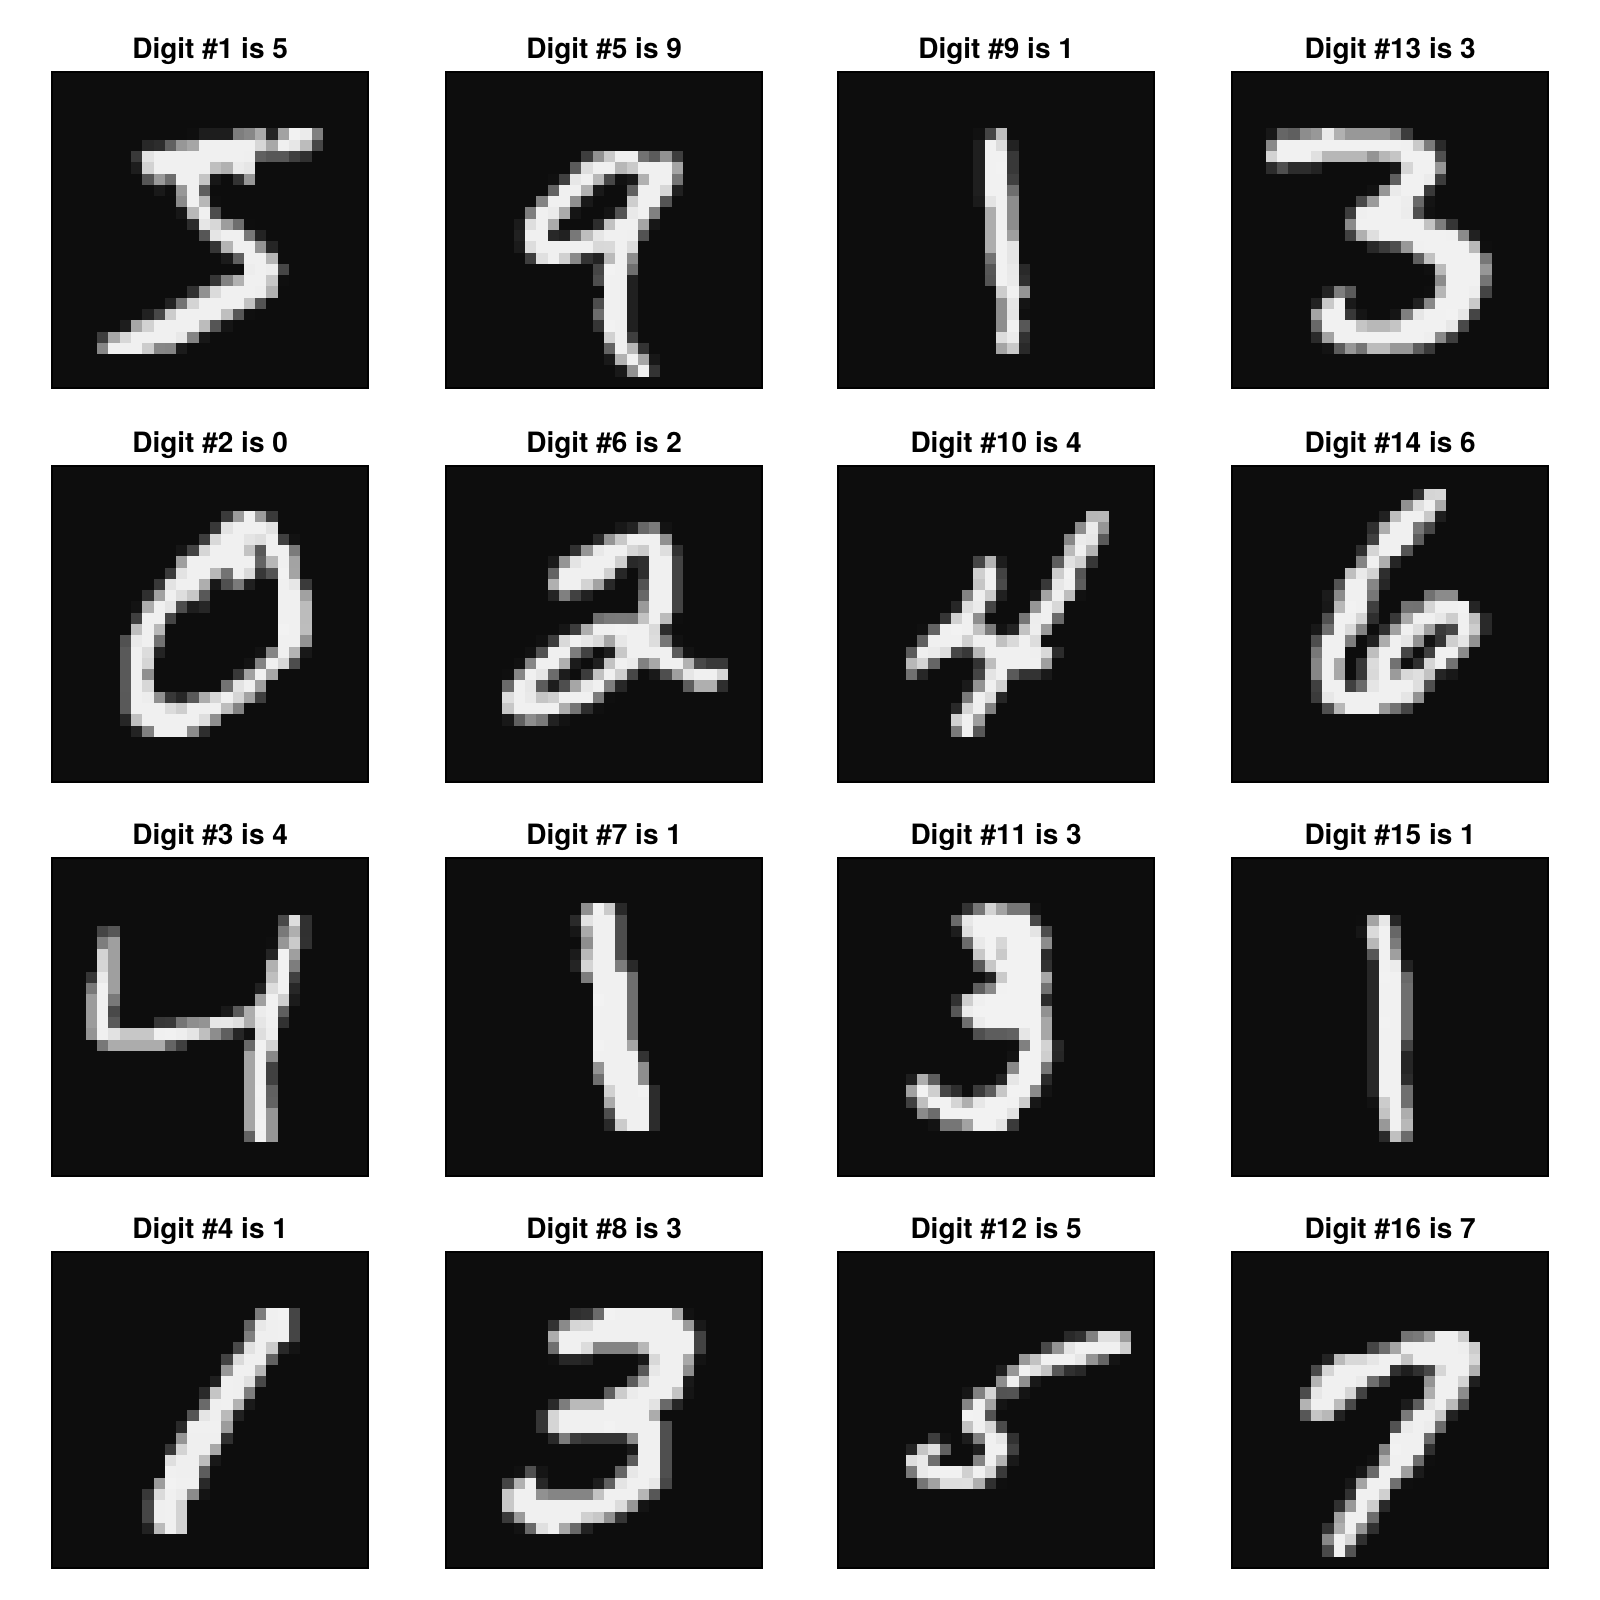

In [6]:
# Now plot a bunch of the first digits
#
# Note that the orientation is with the lowest row at the bottom of the visualisation,
# hence the `yreversed=true` in the Axis.
f = Figure(size=(800,800))
for d in 1:16
    ax = Axis(f[pos(d,4)...], aspect = DataAspect(), yreversed=true,
        title = "Digit #$d is $(Int(data.targets[d]))",)
    hidedecorations!(ax)
    heatmap!(ax, data.features[:, :, d], 
        colormap = :grays,
    )
end
f

## Network Definition

We define a network that takes the 28x28 input image array (vector of 784), passes it through two hidden layers of 1000 neurons, then the output layer is 10 neurons, passed through softmax.

In [7]:
dense_model = Chain(
    Dense(28 * 28, 1000, relu),
    Dense(1000, 1000, relu),
    Dense(1000, 10),
    softmax
)

Chain(
  Dense(784 => 1000, relu),             # 785_000 parameters
  Dense(1000 => 1000, relu),            # 1_001_000 parameters
  Dense(1000 => 10),                    # 10_010 parameters
  NNlib.softmax,
)                   # Total: 6 arrays, 1_796_010 parameters, 6.852 MiB.

In [8]:
dense_model(reshape(data.features[:, :, 1], (784, 1)))

10×1 Matrix{Float32}:
 0.11723679
 0.11277259
 0.10540519
 0.07242866
 0.1211346
 0.09013562
 0.095846556
 0.08390579
 0.107116394
 0.094017796

In [9]:
const classes = sort(unique(data.targets))

10-element Vector{Int64}:
 0
 1
 2
 3
 4
 5
 6
 7
 8
 9

In [10]:
flux_y_onehot = onehotbatch(data.targets, classes)

10×60000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1
 ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

In [11]:
flux_x = reshape(data.features, (28 * 28, size(data.features, 3)));

In [12]:
function flux_loss(flux_model, features, labels_onehot)
    ŷ = flux_model(features)
    Flux.logitcrossentropy(ŷ, labels_onehot)
end;

In [13]:
flux_loss(dense_model, flux_x, flux_y_onehot)

2.3005757f0

In [14]:
flux_accuracy(x, y) = mean(Flux.onecold(dense_model(x), classes) .== y);

In [15]:
flux_accuracy(flux_x, data.targets)

0.13008333333333333

In [16]:
function train_flux_model!(f_loss, model, features, labels_onehot)
    dLdm, _, _ = gradient(f_loss, model, features, labels_onehot)
    @. model[1].weight = model[1].weight - 0.1 * dLdm[:layers][1][:weight]
    @. model[1].bias = model[1].bias - 0.1 * dLdm[:layers][1][:bias]
end;

In [17]:
train_flux_model!(flux_loss, dense_model, flux_x, flux_y_onehot);

In [18]:
for i = ProgressBar(1:100)
    train_flux_model!(flux_loss, dense_model, flux_x, flux_y_onehot);
    # flux_accuracy(flux_x, flux_y_onehot) >= 0.98 && break
end

0.0%┣                                              ┫ 0/100 [00:00<00:00, -0s/it]
1.0%┣▍                                         ┫ 1/100 [00:04<Inf:Inf, InfGs/it]
2.0%┣█                                              ┫ 2/100 [00:07<12:14, 7s/it]
3.0%┣█▍                                             ┫ 3/100 [00:10<08:28, 5s/it]
4.0%┣█▉                                             ┫ 4/100 [00:14<07:30, 5s/it]
5.0%┣██▍                                            ┫ 5/100 [00:17<06:38, 4s/it]
6.0%┣██▉                                            ┫ 6/100 [00:20<06:10, 4s/it]
7.0%┣███▎                                           ┫ 7/100 [00:22<05:34, 4s/it]
8.0%┣███▊                                           ┫ 8/100 [00:24<05:15, 3s/it]
9.0%┣████▎                                          ┫ 9/100 [00:26<04:58, 3s/it]
10.0%┣████▌                                        ┫ 10/100 [00:28<04:42, 3s/it]
11.0%┣█████                                        ┫ 11/100 [00:31<04:34, 3s/it]
12.0%┣█████▍                

In [20]:
flux_accuracy(flux_x, data.targets)

0.4918166666666667